# MNIST classification

該範例講述如何用 tf 簡單的做出手寫辨識

- build model
- train / evalate
- save model

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('data/mnist', one_hot=True)

import os
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
print(f"tensorflow version {tf.__version__}")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
tensorflow version 1.11.0


In [2]:
def argparser():
    parser = argparse.ArgumentParser()
    
    # training parameter
    parser.add_argument('--gpu', dest='gpu', required=True, \
                        help='require one GPU to execute')
    parser.add_argument('--lr', dest='lr', \
                        default=0.1, type=float, \
                        help='learning rate')
    parser.add_argument('--steps', dest='steps', \
                        default=500, type=int, \
                        help='number of update steps')
    parser.add_argument('--bz', dest='bz', \
                        default=128, type=int, \
                        help='batch size')
    parser.add_argument('--display-steps', dest='display_steps', \
                        default=100, type=int, \
                        help='display steps')
    
    # network parameter
    parser.add_argument('--neurons', dest='neurons', \
                        default=[256, 256], nargs='+', type=int, \
                        help='hidden neurons')
    parser.add_argument('--num-input', dest='n_input', \
                        default=784, type=int)
    parser.add_argument('--num-class', dest='n_output', \
                        default=10, type=int)
    parser.add_argument('--ckpt-savepath', dest='ckpt_savepath', \
                        default='outputs/00_mnist_basic/mnist.ckpt')
    return parser

# setting args
args = argparser().parse_args([
    '--gpu', '3',
    '--lr', '0.0001',
    '--neurons', '512', '512', '512'
])
print(args)
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

Namespace(bz=128, ckpt_savepath='outputs/00_mnist_basic/mnist.ckpt', display_steps=100, gpu='3', lr=0.0001, n_input=784, n_output=10, neurons=[512, 512, 512], steps=500)


In [3]:
# tf Graph input placeholder
X = tf.placeholder('float', [None, args.n_input])
Y = tf.placeholder('float', [None, args.n_output])

# store layer weights and bias
weights = {}
bias = {}
last_num_neurons = args.n_input
for nid, neuron in enumerate(args.neurons):
    weights.update({
        f"h{nid+1}": tf.Variable(tf.random_normal([last_num_neurons, neuron]))
    })
    bias.update({
        f"h{nid+1}": tf.Variable(tf.random_normal([neuron]))
    })
    last_num_neurons = neuron
weights.update({
    'out': tf.Variable(tf.random_normal([last_num_neurons, args.n_output]))})
bias.update({
    'out': tf.Variable(tf.random_normal([args.n_output]))})

In [4]:
# create model
def build_model(x, n_hidden_layer, w, b):
    # hidden fully connected layer with neurons
    for i in range(0, n_hidden_layer):
        x = tf.add(tf.matmul(x, w[f"h{i+1}"]), b[f"h{i+1}"])
    # output fully connected layer for each class
    out = tf.matmul(x, w['out']) + b['out']
    return out

# construct model
logits = build_model(X, len(args.neurons), weights, bias)
y_pred = tf.nn.softmax(logits)

# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(
    learning_rate=args.lr)
update_op = optimizer.minimize(loss_op)

# evaluate model
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# init the variable (assign the default value)
init = tf.global_variables_initializer()

In [5]:
saver = tf.train.Saver()

# train model
with tf.Session() as sess:
    # run the init
    sess.run(init)
    
    # iteration update the weight and bias
    for step in range(1, args.steps):
        batch_x, batch_y = mnist_data.train.next_batch(args.bz)
        # run optimization operation (back propagation)
        sess.run(update_op, feed_dict={X: batch_x, Y: batch_y})
        if step % args.display_steps == 0 or step == 1:
            # calc batch loss and acc
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                X: batch_x, Y: batch_y
            })
            print(f"Step {step:4d}, " +\
                    f"minibatch loss={loss:.4f}, "+\
                    f"training accuracy={acc:.3f}")
    print('optimization finished')
    
    # save model
    ckpt_savepath = Path(args.ckpt_savepath)
    if not ckpt_savepath.parent.exists():
        ckpt_savepath.parent.mkdir(parents=True)
    ckpt_savepath = saver.save(sess, args.ckpt_savepath)
    print(f"Model saved in {args.ckpt_savepath}")

Step    1, minibatch loss=163501.5156, training accuracy=0.070
Step  100, minibatch loss=48294.5820, training accuracy=0.344
Step  200, minibatch loss=31940.3477, training accuracy=0.484
Step  300, minibatch loss=20963.5508, training accuracy=0.562
Step  400, minibatch loss=9718.2217, training accuracy=0.758
optimization finished
Model saved in outputs/00_mnist_basic/mnist.ckpt


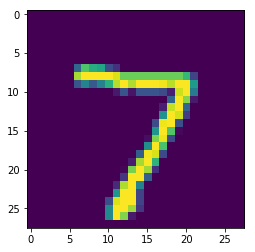

INFO:tensorflow:Restoring parameters from outputs/00_mnist_basic/mnist.ckpt
Model restored from outputs/00_mnist_basic/mnist.ckpt
Testing accuracy: 0.7534000277519226
Predict image label = [7]


In [6]:
plt.imshow(mnist_data.test.images[0].reshape((28, 28)))
plt.show()

with tf.Session() as sess:
    sess.run(init)
    
    # restore model
    saver.restore(sess, args.ckpt_savepath)
    print(f"Model restored from {args.ckpt_savepath}")
    
    # calc accuracy for MNIST test images
    print(f"Testing accuracy: {sess.run(accuracy, feed_dict={\
            X: mnist_data.test.images, Y: mnist_data.test.labels})}")
    
    # predict first test image
    print(f"Predict image label = {sess.run(tf.argmax(y_pred, 1), feed_dict={\
            X: mnist_data.test.images[0:1]})}")